# Think Bayes: Chapter 5

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Beta
import thinkplot

## Odds

The following function converts from probabilities to odds.

In [2]:
def Odds(p):
    return p / (1-p)

And this function converts from odds to probabilities.

In [3]:
def Probability(o):
    return o / (o+1)

If 20% of bettors think my horse will win, that corresponds to odds of 1:4, or 0.25.

In [4]:
p = 0.2
Odds(p)

0.25

If the odds against my horse are 1:5, that corresponds to a probability of 1/6.

In [5]:
o = 1/5
Probability(o)

0.16666666666666669

We can use the odds form of Bayes's theorem to solve the cookie problem:

In [6]:
prior_odds = 1
likelihood_ratio = 0.75 / 0.5
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

And then we can compute the posterior probability, if desired.

In [7]:
post_prob = Probability(post_odds)
post_prob

0.6

If we draw another cookie and it's chocolate, we can do another update:

In [8]:
likelihood_ratio = 0.25 / 0.5
post_odds *= likelihood_ratio
post_odds

0.75

And convert back to probability.

In [9]:
post_prob = Probability(post_odds)
post_prob

0.42857142857142855

## Oliver's blood

The likelihood ratio is also useful for talking about the strength of evidence without getting bogged down talking about priors.

As an example, we'll solve this problem from MacKay's {\it Information Theory, Inference, and Learning Algorithms}:

> Two people have left traces of their own blood at the scene of a crime.  A suspect, Oliver, is tested and found to have type 'O' blood.  The blood groups of the two traces are found to be of type 'O' (a common type in the local population, having frequency 60) and of type 'AB' (a rare type, with frequency 1). Do these data [the traces found at the scene] give evidence in favor of the proposition that Oliver was one of the people [who left blood at the scene]?

If Oliver is
one of the people who left blood at the crime scene, then he
accounts for the 'O' sample, so the probability of the data
is just the probability that a random member of the population
has type 'AB' blood, which is 1%.

If Oliver did not leave blood at the scene, then we have two
samples to account for.  If we choose two random people from
the population, what is the chance of finding one with type 'O'
and one with type 'AB'?  Well, there are two ways it might happen:
the first person we choose might have type 'O' and the second
'AB', or the other way around.  So the total probability is
$2 (0.6) (0.01) = 1.2$%.

So the likelihood ratio is:

In [10]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

Since the ratio is less than 1, it is evidence *against* the hypothesis that Oliver left blood at the scence.

But it is weak evidence.  For example, if the prior odds were 1 (that is, 50% probability), the posterior odds would be 0.83, which corresponds to a probability of:

In [11]:
post_odds = 1 * like1 / like2
Probability(post_odds)

0.45454545454545453

So this evidence doesn't "move the needle" very much.

**Exercise:** Suppose other evidence had made you 90% confident of Oliver's guilt.  How much would this exculpatory evince change your beliefs?  What if you initially thought there was only a 10% chance of his guilt?

Notice that evidence with the same strength has a different effect on probability, depending on where you started.

In [12]:
post_odds = Odds(0.9) * like1 / like2
Probability(post_odds)

0.8823529411764706

In [13]:
post_odds = Odds(0.1) * like1 / like2
Probability(post_odds)

0.0847457627118644

## Comparing distributions

Let's get back to the Kim Rhode problem from Chapter 4:

> At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 targets, sending the match into sudden death. In the first round, both hit 1 of 2 targets. In the next two rounds, they each hit 2 targets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

>But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

I'll start with a uniform distribution for `x`, the probability of hitting a target, but we should check whether the results are sensitive to that choice.

First I create a Beta distribution for each of the competitors, and update it with the results.

In [14]:
rhode = Beta(1, 1, label='Rhode')
rhode.Update((22, 11))

In [15]:
wei = Beta(1, 1, label='Wei')
wei.Update((21, 12))

Based on the data, the distribution for Rhode is slightly farther right than the distribution for Wei, but there is a lot of overlap.

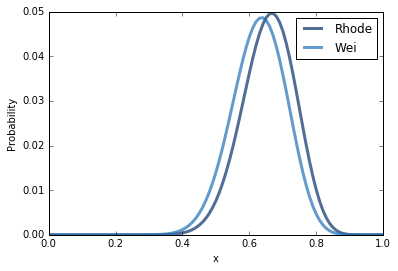

In [16]:
thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(wei.MakePmf())
thinkplot.Config(xlabel='x', ylabel='Probability')

To compute the probability that Rhode actually has a higher value of `p`, there are two options:

1. Sampling: we could draw random samples from the posterior distributions and compare them.

2. Enumeration: we could enumerate all possible pairs of values and add up the "probability of superiority".

I'll start with sampling.  The Beta object provides a method that draws a random value from a Beta distribution:

In [17]:
iters = 1000
count = 0
for _ in range(iters):
    x1 = rhode.Random()
    x2 = wei.Random()
    if x1 > x2:
        count += 1

count / iters

0.603

`Beta` also provides `Sample`, which returns a NumPy array, so we an perform the comparisons using array operations:

In [18]:
rhode_sample = rhode.Sample(iters)
wei_sample = wei.Sample(iters)
np.mean(rhode_sample > wei_sample)

0.60899999999999999

The other option is to make `Pmf` objects that approximate the Beta distributions, and enumerate pairs of values:

In [19]:
def ProbGreater(pmf1, pmf2):
    total = 0
    for x1, prob1 in pmf1.Items():
        for x2, prob2 in pmf2.Items():
            if x1 > x2:
                total += prob1 * prob2
    return total

In [20]:
pmf1 = rhode.MakePmf(1001)
pmf2 = wei.MakePmf(1001)
ProbGreater(pmf1, pmf2)

0.5982856085975615

In [21]:
pmf1.ProbGreater(pmf2)

0.5982856085975615

In [22]:
pmf1.ProbLess(pmf2)

0.3983148672663459

**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

## Simulation

To make predictions about a rematch, we have two options again:

1. Sampling.  For each simulated match, we draw a random value of `x` for each contestant, then simulate 25 shots and count hits.

2. Computing a mixture.  If we knew `x` exactly, the distribution of hits, `k`, would be binomial.  Since we don't know `x`, the distribution of `k` is a mixture of binomials with different values of `x`.

I'll do it by sampling first.

In [23]:
import random

def flip(p):
    return random.random() < p

`flip` returns True with probability `p` and False with probability `1-p`

Now we can simulate 1000 rematches and count wins and losses.

In [24]:
iters = 1000
wins = 0
losses = 0

for _ in range(iters):
    x1 = rhode.Random()
    x2 = wei.Random()
    
    count1 = count2 = 0
    for _ in range(25):
        if flip(x1):
            count1 += 1
        if flip(x2):
            count2 += 1
            
    if count1 > count2:
        wins += 1
    if count1 < count2:
        losses += 1
        
wins/iters, losses/iters

(0.533, 0.38)

Or, realizing that the distribution of `k` is binomial, we can simplify the code using NumPy:

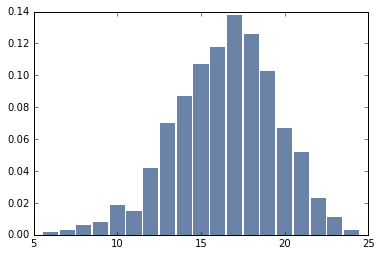

In [25]:
rhode_rematch = np.random.binomial(25, rhode_sample)
thinkplot.Hist(Pmf(rhode_rematch))

In [26]:
wei_rematch = np.random.binomial(25, wei_sample)
np.mean(rhode_rematch > wei_rematch)

0.51600000000000001

In [27]:
np.mean(rhode_rematch < wei_rematch)

0.39000000000000001

Alternatively, we can make a mixture that represents the distribution of `k`, taking into account our uncertainty about `x`:

In [28]:
from thinkbayes2 import MakeBinomialPmf

def MakeBinomialMix(pmf, label=''):
    mix = Pmf(label=label)
    for x, prob in pmf.Items():
        binom = MakeBinomialPmf(n=25, p=x)
        for k, p in binom.Items():
            mix[k] += prob * p
    return mix

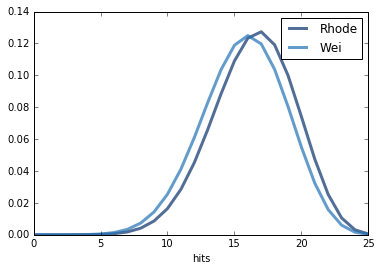

In [29]:
rhode_rematch = MakeBinomialMix(rhode.MakePmf(), label='Rhode')
wei_rematch = MakeBinomialMix(wei.MakePmf(), label='Wei')
thinkplot.Pdf(rhode_rematch)
thinkplot.Pdf(wei_rematch)
thinkplot.Config(xlabel='hits')

In [30]:
rhode_rematch.ProbGreater(wei_rematch), rhode_rematch.ProbLess(wei_rematch)

(0.52023290455545201, 0.39052602488401122)

Alternatively, we could use MakeMixture:

In [31]:
from thinkbayes2 import MakeMixture

def MakeBinomialMix2(pmf):
    binomials = Pmf()
    for x, prob in pmf.Items():
        binom = MakeBinomialPmf(n=25, p=x)
        binomials[binom] = prob
    return MakeMixture(binomials)

Here's how we use it.

In [32]:
rhode_rematch = MakeBinomialMix2(rhode.MakePmf())
wei_rematch = MakeBinomialMix2(wei.MakePmf())
rhode_rematch.ProbGreater(wei_rematch), rhode_rematch.ProbLess(wei_rematch)

(0.52023290455545168, 0.39052602488401117)

**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

## Distributions of sums and differences

Suppose we want to know the total number of targets the two contestants will hit in a rematch.  There are two ways we might compute the distribution of this sum:

1. Sampling: We can draw samples from the distributions and add them up.

2. Enumeration: We can enumerate all possible pairs of values.

I'll start with sampling:

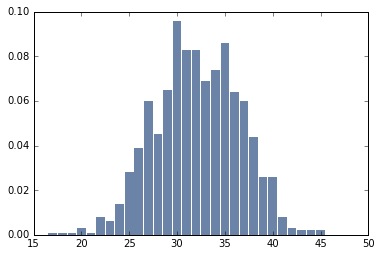

In [33]:
iters = 1000
pmf = Pmf()
for _ in range(iters):
    k = rhode_rematch.Random() + wei_rematch.Random()
    pmf[k] += 1
pmf.Normalize()
thinkplot.Hist(pmf)

Or we could use `Sample` and NumPy:

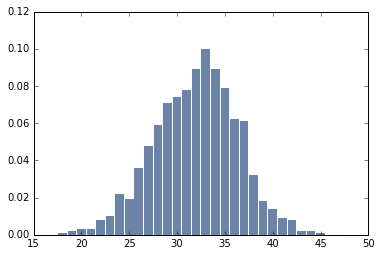

In [34]:
ks = rhode_rematch.Sample(iters) + wei_rematch.Sample(iters)
pmf = Pmf(ks)
thinkplot.Hist(pmf)

Alternatively, we could compute the distribution of the sum by enumeration:

In [35]:
def AddPmfs(pmf1, pmf2):
    pmf = Pmf()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            pmf[v1 + v2] += p1 * p2
    return pmf

Here's how it's used:

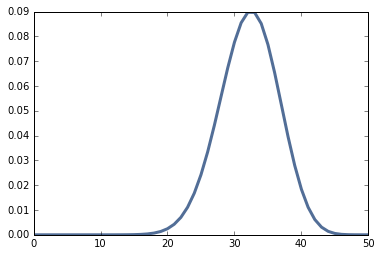

In [36]:
pmf = AddPmfs(rhode_rematch, wei_rematch)
thinkplot.Pdf(pmf)

The `Pmf` class provides a `+` operator that does the same thing.

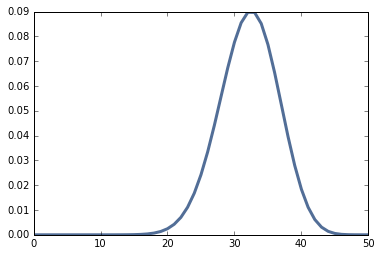

In [37]:
pmf = rhode_rematch + wei_rematch
thinkplot.Pdf(pmf)

**Exercise:**  The Pmf class also provides the `-` operator, which computes the distribution of the difference in values from two distributions.  Use the distributions from the previous section to compute the distribution of the differential between Rhode and Wei in a rematch.  On average, how many clays should we expect Rhode to win by?  What is the probability that Rhode wins by 10 or more?

0.011732128643032563

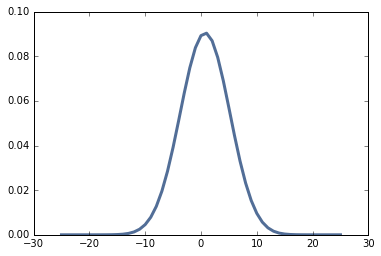

In [38]:
pmf = rhode_rematch - wei_rematch
thinkplot.Pdf(pmf)
pmf.ProbGreater(10)

In [39]:
sum(pmf.Probs(range(11, 26)))
#print(pmf.Probs(range(11, 26)))

0.011732128643032563

In [40]:
# Solution goes here

## Distribution of maximum

Suppose Kim Rhode continues to compete in six more Olympics.  What should we expect her best result to be?

Once again, there are two ways we can compute the distribution of the maximum:

1. Sampling.

2. Analysis of the CDF.

Here's a simple version by sampling:

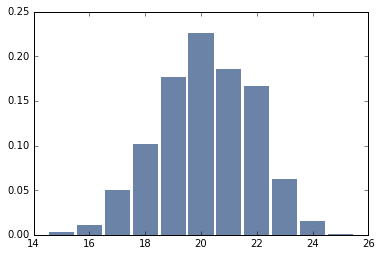

In [41]:
iters = 1000
pmf = Pmf()
for _ in range(iters):
    # Simulate 6 Olympics, where ks gives results. Save the maximum result, and iterate
    ks = rhode_rematch.Sample(6)
    pmf[max(ks)] += 1
pmf.Normalize()
thinkplot.Hist(pmf)

And here's a version using NumPy.  I'll generate an array with 6 rows and 10 columns:

In [42]:
iters = 1000
ks = rhode_rematch.Sample((6, iters))
ks

array([[18, 16,  9, ..., 22, 17, 21],
       [14, 16, 18, ..., 18, 20, 22],
       [18, 18, 15, ..., 20, 12, 21],
       [14, 13, 13, ..., 12,  7, 17],
       [21, 16, 19, ..., 18, 14, 18],
       [15,  9, 13, ..., 13, 21, 12]])

Compute the maximum in each column:

In [43]:
maxes = np.max(ks, axis=0)
maxes[:10]

array([21, 18, 19, 19, 22, 19, 19, 19, 22, 20])

And then plot the distribution of maximums:

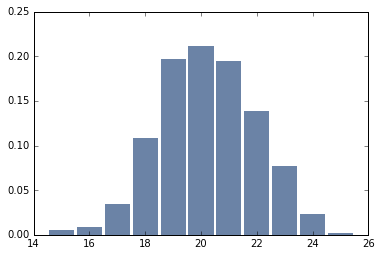

In [44]:
pmf = Pmf(maxes)
thinkplot.Hist(pmf)

Or we can figure it out analytically.  If the maximum is less-than-or-equal-to some value `k`, all 6 random selections must be less-than-or-equal-to `k`, so: 

$ CDF_{max}(x) = CDF(x)^6 $

`Pmf` provides a method that computes and returns this `Cdf`, so we can compute the distribution of the maximum like this:

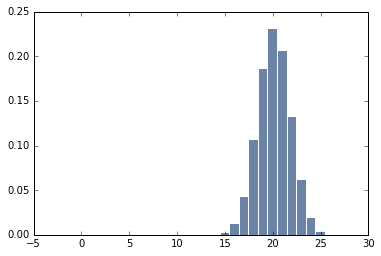

In [45]:
pmf = rhode_rematch.Max(6).MakePmf()
thinkplot.Hist(pmf)

**Exercise:**  Here's how Pmf.Max works:

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps **= k
        return cdf

Write a function that takes a Pmf and an integer `n` and returns a Pmf that represents the distribution of the minimum of `k` values drawn from the given Pmf.  Use your function to compute the distribution of the minimum score Kim Rhode would be expected to shoot in six competitions.

In [46]:
def Min(pmf, k):
    cdf = pmf.MakeCdf()
    cdf.ps = 1 - (1-cdf.ps)**k
    return cdf

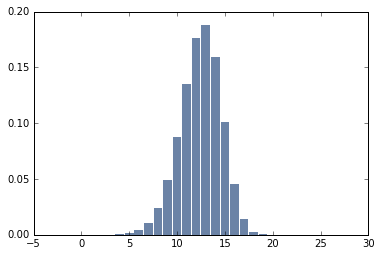

In [47]:
pmf = Min(rhode_rematch, 6).MakePmf()
thinkplot.Hist(pmf)

## Exercises

**Exercise:**  Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats.  Because you have cats, you expect 50% of the allergic guests to sneeze during dinner.  At the same time, you expect 10% of the non-allergic guests to sneeze.  What is the distribution of the total number of guests who sneeze?

So this is not really a Bayes' problem because it is predicting what will happen forward in time. I can manually calculate the probability of 1 guest sneezing given the number of guests and my prediction of the percentage that will sneeze. A Baye's problem would be, given the number of people who sneezed, how many are actually allergic to cats. AND THAT"S BASICALLY THE NEXT PROBLEM!!!! So I know the likelihood function now. IT MAKES SENSE!

4

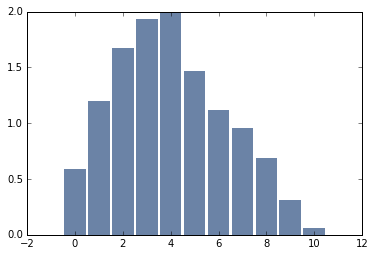

In [50]:
num_guests = 10
num_allergic = 4
num_not = num_guests - num_allergic
sneeze_if_allergic = 0.5
sneeze_if_not = 0.1
pmf = Pmf()

# Loop through the possible num of sneezes non allergic people will experience, and num sneezes allergic people will
# Probability of a number of sneezes happening is combined probability of above two
# distribution of non-allergic people sneezing
for sneeze_not in range(num_not + 1):
    # distribution of the allergic people sneezing
    for sneeze_allergic in range(num_allergic + 1):
        prob_not = stats.binom.pmf(sneeze_not, num_not, sneeze_if_not)
        prob_allergic = stats.binom.pmf(sneeze_allergic, num_allergic, sneeze_if_allergic)
        pmf[sneeze_not + sneeze_allergic] += prob_not + prob_allergic
thinkplot.Hist(pmf)
pmf.MaximumLikelihood()

Previous attempt at solving this problem, using Baye's approach which is not really relevant to this scenario.

2

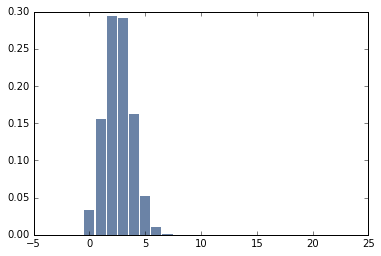

In [51]:
from scipy.special import binom
import scipy.stats as stats

# We can create 2 different types of guests: allergic and non-allergic.
# Each will be a different object, basically with a slightly different Likelihood function
# I will create a distribution of how many people will sneeze in the different groups
# and then add them together.
class Allergic(Suite):
    '''data: tuple of whether guests are allergic and how many there are
    hypo: num_guests that sneeze'''
    def Likelihood(self, data, hypo):
        allergic, num_guests = data
        k = hypo # num guests who sneeze
        p = 0.1
        if allergic:
            p = 0.5
        return stats.binom.pmf(k, num_guests, p) # I think what I'm getting here is the probability
                                                # that out of num_guests, k sneeze if they have a
                                                # probability p of sneezing

total_guests = 10
num_allergic = 4
allergic = Allergic(range(total_guests + 1))
allergic.Update((True, num_allergic))
non_allergic = Allergic(range(total_guests + 1))
non_allergic.Update((False, total_guests - num_allergic))
combined = allergic + non_allergic
thinkplot.Hist(combined)
combined.MaximumLikelihood()

In [52]:
combined.Mean()

2.6000000000000001

**Exercise** [This study from 2015](http://onlinelibrary.wiley.com/doi/10.1111/apt.13372/full) showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

// Double blind means that neither the participants nor the researchers know which group, control or test, the subjects belong to.
Here is a description of the study:

>"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
>"The gluten-containing ﬂour was correctly identiﬁed by 12 participants (34%)..."
Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

We can use a Bayesian approach to interpret the results more precisely.  But first we have to make some modeling decisions.

1. Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple I follow the authors of the study and lump together the second two groups; that is, I consider two groups: those who identified the gluten flour and those who did not.

2. I assume (1) people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and (2) subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Using this model, estimate the number of study participants who are sensitive to gluten.  What is the most likely number?  What is the 95% credible interval?

Unlike the previous problem, this is a Bayes' problem. Instead of asking the question how many subjects will correctly identify the gluten given this many are allergic, it asks the question of how many are allergic given that this many subjects identified it as such.

So, we have already solved p(D|H) in the problem aboce, just change some numbers. All we need is a prior of the distribution of the likelihood that a certain number of subjects are gluten free. To start simply, we can assume a uniform prior.

So: the hypothesis are the number of people who are allergic to gluten. Data under the hypothesis is what is the probability of a number of people identifying gluten if this number of people are allergic.

In [1]:
from scipy.special import binom
import scipy.stats as stats

class Gluten(Suite):
    '''data: tuple of whether identified gluten and how many there are
    hypo: number of people allergic to gluten
    We are looking for: if this many people are allergic, how many will identify the gluten'''
    def Likelihood(self, data, hypo):
        identify, num_subjects = data
        k = hypo # num subjects identify/don't identify gluten
        p = 0.4 # probability will identify gluten if not allergic
        if identify:
            p = 0.95 # probability will identify gluten if allergic
        return stats.binom.pmf(k, num_subjects, p)

total_subjects = 35
num_identified = 12
identified = Gluten(range(total_subjects + 1))
identified.Update((True, num_identified))
non_identified = Gluten(range(total_subjects + 1))
non_identified.Update((False, total_subjects - num_identified))
combined = identified + non_identified
thinkplot.Pmf(combined)
combined.MaximumLikelihood()
#combined.CredibleInterval(50)

NameError: name 'Suite' is not defined

In [54]:
# Solution goes here

In [55]:
# Solution goes here

In [56]:
# Solution goes here

In [57]:
# Solution goes here

**Exercise** 
In preparation for an alien invasion, the Earth Defense League has been working on new missiles to shoot down space invaders. Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship x.

Based on previous tests, the distribution of x in the population of designs is well-modeled by a beta distribution with paramters alpha = 2 and beta = 3. What is the average missile's probability of shooting down an alien?

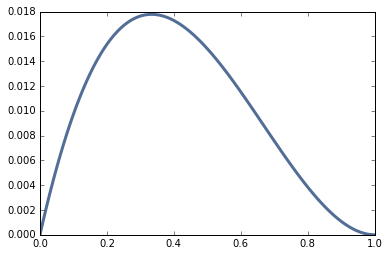

In [58]:
shootingDownDistribution = Beta(2, 3)
thinkplot.Pdf(shootingDownDistribution.MakePmf())

In [59]:
shootingDownDistribution.Mean()

0.4

In its first test, the new Alien Blaster 9000 takes 10 shots and hits 2 targets. Taking into account this data, what is the posterior distribution of x for this missile? What is the value in the posterior with the highest probability, also known as the MAP?

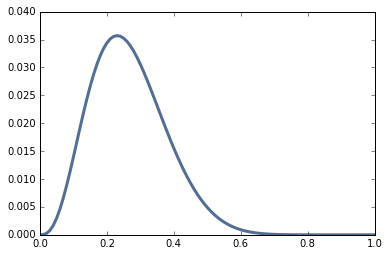

In [60]:
shootingDownDistribution.Update((2, 8))
thinkplot.Pdf(shootingDownDistribution.MakePmf())

In [61]:
shootingDownDistribution.MakePmf().MaximumLikelihood()

0.23

Now suppose the new ultra-secret Alien Blaster 10K is being tested. In a press conference, an EDF general reports that the new design has been tested twice, taking two shots during each test. The results of the test are confidential, so the general won't say how many targets were, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Write a class called **AlienBlaster** that inherits from **Suite** and provides a likelihood function that takes this data -- two tests, two shots each, and a tie -- and computes the likelihood of the data for each hypothetical value of *x*. If you would like a challenge, write a version that works for any number of shots.

In [62]:
class AlienBlaster(Suite):
    '''data: result of a test: (num_hit, num_missed)
    hypo: probability x of hitting target'''
    def Likelihood(self, data, hypo):
        num_hit, num_missed = data
        x = hypo
        return x ** (num_hit) + (1 - x) ** (num_missed)

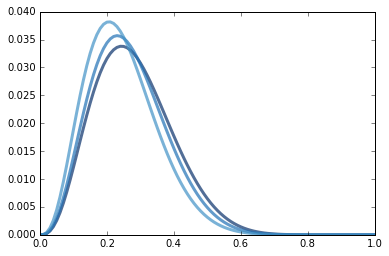

In [63]:
aliensHit = AlienBlaster(shootingDownDistribution.MakePmf(label='Hit')) # darker blue
aliensHit.UpdateSet([(2, 0), (2, 0)])
thinkplot.Pdf(aliensHit)

aliensTie = AlienBlaster(shootingDownDistribution.MakePmf(label='Tie')) # medium blue
aliensTie.UpdateSet([(1, 1), (1, 1)])
thinkplot.Pdf(aliensTie)

aliensMiss = AlienBlaster(shootingDownDistribution.MakePmf(label='Miss')) # light blue
aliensMiss.UpdateSet([(0, 2), (0, 2)])
thinkplot.Pdf(aliensMiss)

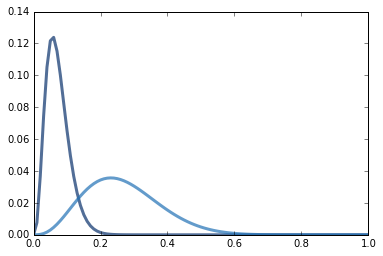

In [64]:
aliensDiff = AlienBlaster(shootingDownDistribution.MakePmf(label='Diff')) # medium blue
aliensDiff.UpdateSet([(1111150, 40), (11150, 0)])
thinkplot.Pdf(aliensDiff)
thinkplot.Pdf(shootingDownDistribution.MakePmf(label='orig'))

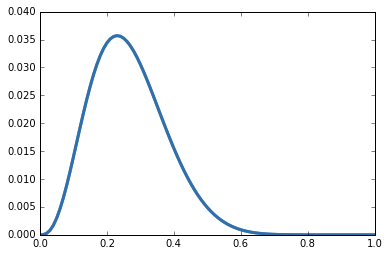

In [65]:
aliensDiff = AlienBlaster(shootingDownDistribution.MakePmf(label='Diff')) # medium blue
aliensDiff.UpdateSet([(1111150, 0), (11150, 0)])
thinkplot.Pdf(aliensDiff)
thinkplot.Pdf(shootingDownDistribution.MakePmf(label='orig'))

In [114]:
class AlienBlaster(Suite):
    '''data: both tests hit 0, 1, OR 2 targets aka the same number of targets!!!
    hypo: probability x of hitting target'''
    def Likelihood(self, data, hypo):
        x = hypo
        prob_both_miss = ((1 - x) ** 2)**2
        prob_both_tie = (x * (1 - x) * 2)**2
        prob_both_hit = (x ** 2)**2
        return prob_both_miss + prob_both_tie + prob_both_hit

0.2

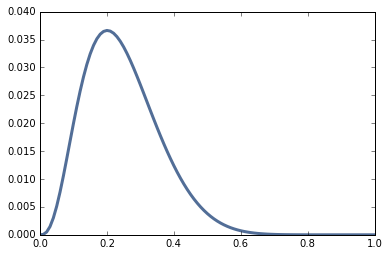

In [115]:
shootingDownDistribution = Beta(2, 3)
shootingDownDistribution.Update((2, 8))

aliens = AlienBlaster(shootingDownDistribution.MakePmf())
aliens.Update('data')
thinkplot.Pdf(aliens)
aliens.MaximumLikelihood()

In [116]:
class AlienBlaster2(Suite):
    '''data: tuple of num_tests and num_shots, and that the results were the same in all tests
    hypo: probability x of hitting target'''
    def Likelihood(self, data, hypo):
        num_tests, num_shots = data
        x = hypo
        total_prob = 0
        for hits in range(num_shots + 1):
            prob_hitting = stats.binom.pmf(hits, num_shots, x) ** num_tests
            total_prob += prob_hitting
        return total_prob

0.2

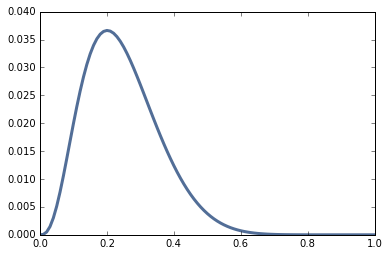

In [117]:
shootingDownDistribution = Beta(2, 3)
shootingDownDistribution.Update((2, 8))

aliens = AlienBlaster2(shootingDownDistribution.MakePmf())
aliens.Update((2, 2))
thinkplot.Pdf(aliens)
aliens.MaximumLikelihood()

0.03

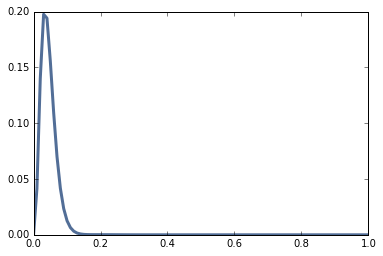

In [118]:
shootingDownDistribution = Beta(2, 3)
shootingDownDistribution.Update((2, 8))

aliens = AlienBlaster2(shootingDownDistribution.MakePmf())
aliens.Update((15, 5))
thinkplot.Pdf(aliens)
aliens.MaximumLikelihood()

I don't understand. Why when I update it saying that look, there have been 150 tests run, with 50 shots each, and each of them performed the same way. Shouldn't that shift the distribution to the right and not left? Given the prior distribution, where the likelihood of hitting a target, agreed, isn't super high, should not that increase the chances? Or does that convince you that well, they did the same, there is a greater probability that they all failed, and that skews the whole thing?